In [753]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [754]:
# TO DO
# need to figure out how to ger around ema_a > ema_b on second time while rsi check is positive.
# dkng u path nvda arkg pltr ttd sofi ionq tsla googl celh arm rblx hcp ai joby

In [755]:
ticker = 'celh'

In [756]:
# Fetch data for a ticker
df = yf.download(ticker, start='2024-01-01', end='2024-09-27')

[*********************100%%**********************]  1 of 1 completed


In [757]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,54.060001,59.139999,53.029999,59.029999,59.029999,6346600
2024-01-03,58.680000,59.680000,55.139999,55.360001,55.360001,4936500
2024-01-04,55.599998,58.660000,54.619999,56.549999,56.549999,4771300
2024-01-05,56.349998,59.330002,55.610001,57.279999,57.279999,3795800
2024-01-08,57.110001,58.160000,54.020000,58.150002,58.150002,4166200


In [758]:
# Calculate moving averages 5|7 3|21 5|13
df['EMA_A'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_B'] = df['Close'].ewm(span=7, adjust=False).mean()

In [759]:
# Calculate the RSI
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

# Define the overbought and oversold levels (typically 70 and 30, respectively)
overbought_level = float(80.0)
oversold_level = float(30.0)

# Compute the median between overbought and oversold levels
median_rsi = np.median([overbought_level, oversold_level])

# Add the Median_RSI column indicating whether RSI is above or below the median
df['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

# add rsi column with rsi value
df['rsi'] = rsi

# ensure rsi is above median to be used in the crossed_above condition
rsi_check = df['rsi'] > median_rsi

In [760]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)

In [761]:
# Identify when the 5-day EMA crosses above the 21-day EMA & rsi_check condition is met
crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) & (rsi_check) 

# Identify when the 5-day EMA crosses above the 21-day EMA
# crossed_above = (df['EMA_A'] > df['EMA_B']) & (df['EMA_A'].shift(1) < df['EMA_B'].shift(1)) 

In [762]:
# # # Identify when the MACD line crosses below the signal line
# crossed_above = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))

In [763]:
df.loc[crossed_above, 'Cross_Direction'] = 'crossed up'

In [764]:
# Identify when the A-day EMA crosses below the B-Day EMA
crossed_below = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))
df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [765]:
# # Identify when the A-day EMA crosses below the B-Day EMA
# crossed_below_ema = (df['EMA_A'] < df['EMA_B']) & (df['EMA_A'].shift(1) > df['EMA_B'].shift(1))

# # Identify when the MACD line crosses below the signal line
# crossed_below_macd = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) > df['Signal'].shift(1))

# # Combine both conditions using logical OR operator
# crossed_below = crossed_below_ema | crossed_below_macd

# # Update the 'Cross_Direction' column
# df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [766]:
# # Identify when the MACD line crosses below the signal line
# crossed_below = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) > df['Signal'].shift(1))

# # Update the 'Cross_Direction' column
# df.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

In [767]:
# Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
condition_met = df[df['Cross_Direction'].notna()]

In [768]:
# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2024-01-19,51.990002,57.059680,57.570159,crossed down,below_median,NaN
2024-03-27,83.430000,88.618017,89.075769,crossed down,below_median,42.320223
2024-04-11,80.870003,82.670195,82.832248,crossed down,below_median,32.833793
2024-05-28,82.919998,90.106329,90.458317,crossed down,above_median,57.142857
2024-07-15,52.630001,56.086874,56.435966,crossed down,below_median,31.464178
2024-08-22,39.330002,40.289076,40.358278,crossed down,below_median,39.450698
2024-09-20,33.169998,33.714527,33.758557,crossed down,below_median,32.158592


In [769]:
df

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi,MACD,Signal,Cross_Direction
Date,,,,,,,,,,,,,
2024-01-02,54.060001,59.139999,53.029999,59.029999,59.029999,6346600,59.029999,59.029999,below_median,NaN,0.000000,0.000000,NaN
2024-01-03,58.680000,59.680000,55.139999,55.360001,55.360001,4936500,57.806666,58.112499,below_median,NaN,-0.292763,-0.058553,NaN
2024-01-04,55.599998,58.660000,54.619999,56.549999,56.549999,4771300,57.387777,57.721874,below_median,NaN,-0.423871,-0.131616,NaN
2024-01-05,56.349998,59.330002,55.610001,57.279999,57.279999,3795800,57.351851,57.611405,below_median,NaN,-0.463527,-0.197999,NaN
2024-01-08,57.110001,58.160000,54.020000,58.150002,58.150002,4166200,57.617901,57.746054,below_median,NaN,-0.419913,-0.242381,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20,34.009998,34.169998,32.919998,33.169998,33.169998,7274900,33.714527,33.758557,below_median,32.158592,-2.287125,-2.745968,crossed down
2024-09-23,33.240002,33.880001,32.520000,32.799999,32.799999,7285500,33.409684,33.518917,below_median,34.761907,-2.225248,-2.641824,NaN
2024-09-24,33.099998,33.230000,31.299999,31.629999,31.629999,7717200,32.816456,33.046688,below_median,46.008403,-2.244743,-2.562408,NaN


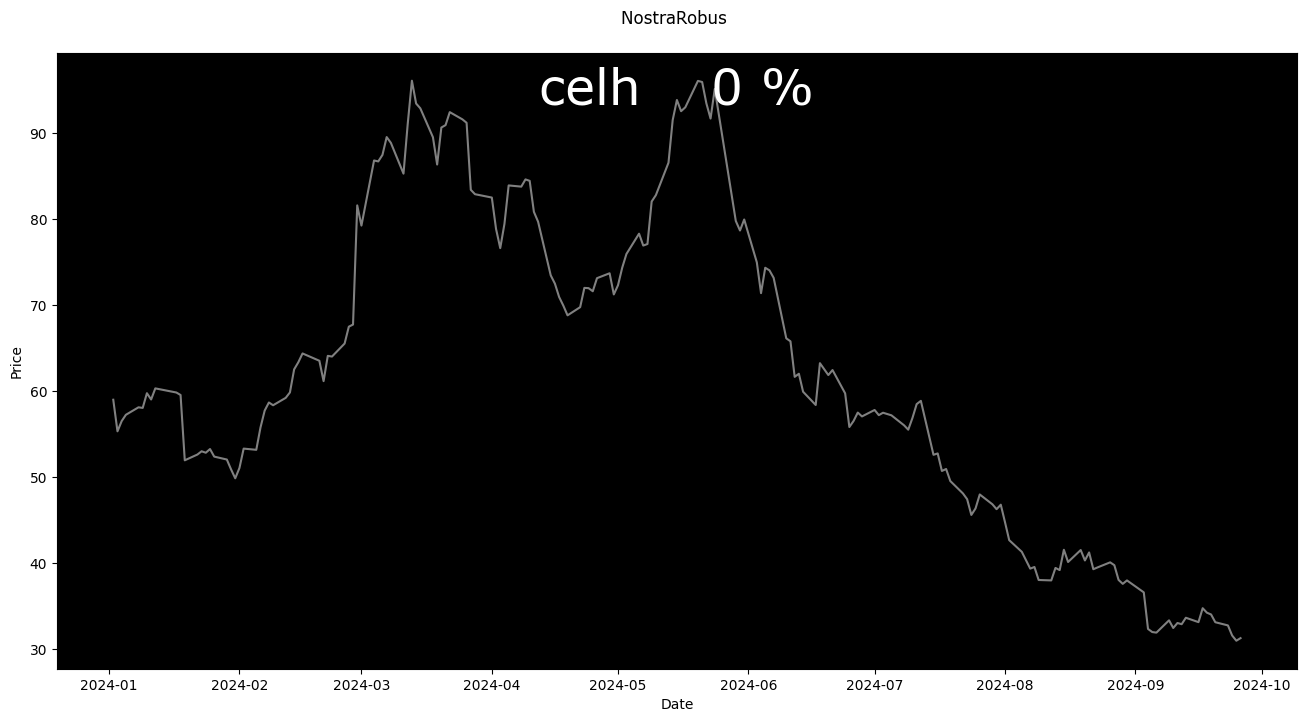

Results For Ticker:   celh
Initial Investment:  1
Final Portfolio Value:  1
Profit/Loss:  0
Percent: 0.0%




,Action,Date,Open,Close,Price,Cash


In [770]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = 'crossed down'
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black



# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
portfolio_value = cash

# Evaluate performance
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment

percent = (profit_loss / initial_investment) * 100

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



In [771]:
# df.to_csv('filename.csv', index=True)
# transactions_df.to_csv('filename.csv', index=True)
